In [1]:
using Printf

using Distributions
using StatsPlots
default(fmt=:png, size=(500, 300),
    titlefontsize=10, tickfontsize=6, guidefontsize=9,
    plot_titlefontsize=10)

# Sterneの信頼区間の定義で使用
using Roots
using StatsFuns: logit

# highest density interval (HDI) の構成で使用
using Optim

In [2]:
safediv(x, y) = x == 0 ? x : y == Inf ? zero(y) : x/y

function pvalue_wilson(k, n, p)
    p̂ = k/n
    se = √(p*(1 - p)/n)
    2ccdf(Normal(0,1), safediv(abs(p̂ - p), se))
end

function confint_wilson(k, n, α)
    z = cquantile(Normal(0,1), α/2)
    p̂ = k/n
    a, b, c = 1 + z^2/n, p̂ + z^2/(2n), p̂^2
    sqrtD = √(b^2 - a*c)
    (b - sqrtD)/a, (b + sqrtD)/a
end

function pvalue_wald(k, n, p)
    p̂ = k/n
    sehat = √(p̂*(1 - p̂)/n)
    2ccdf(Normal(0,1), abs(p̂ - p)/sehat)
end

function confint_wald(k, n, α)
    z = cquantile(Normal(0,1), α/2)
    p̂ = k/n
    sehat = √(p̂*(1 - p̂)/n)
    p̂ - z*sehat, p̂ + z*sehat
end

function pvalue_cp(k, n, p)
    bin = Binomial(n, p)
    min(1, 2cdf(bin, k), 2ccdf(bin, k-1))
end

function confint_cp(k, n, α)
    quantile(Beta(k, n-k+1), α/2), cquantile(Beta(k+1, n-k), α/2)
end

x ⪅ y = x < y || x ≈ y

_pdf_le(x, (dist, y)) =  pdf(dist, x) ⪅ y

function _search_boundary(f, x0, Δx, param)
    x = x0
    if f(x, param)
        while f(x - Δx, param) x -= Δx end
    else
        x += Δx
        while !f(x, param) x += Δx end
    end
    x
end

function pvalue_sterne(dist::DiscreteUnivariateDistribution, x)
    Px = pdf(dist, x)
    Px == 0 && return Px
    Px == 1 && return Px
    m = mode(dist)
    Px ≈ pdf(dist, m) && return one(Px)
    if x < m
        y = _search_boundary(_pdf_le, 2m - x, 1, (dist, Px))
        cdf(dist, x) + ccdf(dist, y-1)
    else # x > m
        y = _search_boundary(_pdf_le, 2m - x, -1, (dist, Px))
        cdf(dist, y) + ccdf(dist, x-1)
    end
end

function pvalue_sterne(k, n, p)
    pvalue_sterne(Binomial(n, p), k)
end

function confint_sterne(k, n, α)
    a, b = confint_cp(k, n, α/10)
    ps = find_zeros(a-√eps(), b+√eps()) do p
        logit(0 < p ≤ 1 ? pvalue_sterne(k, n, p) : zero(p)) - logit(α)
    end
    first(ps), last(ps)
end

confint_sterne (generic function with 1 method)

In [3]:
function expval(f, dist::DiscreteUnivariateDistribution; m=6)
    μ, σ = mean(dist), std(dist)
    a = max(minimum(dist), round(Int, μ - m*σ))
    b = min(maximum(dist), round(Int, μ + m*σ))
    sum(x -> f(x)*pdf(dist, x), a:b)
end

function power(pvalfun, dist::DiscreteUnivariateDistribution; m=6, α=0.05)
    expval(x -> pvalfun(x) < 0.05, dist; m)
end

function power(pvaluefunc, n, p, q; m=6, α=0.05)
    pvalfun(x) = pvaluefunc(x, n, p)
    bin = Binomial(n, q)
    power(pvalfun, bin; m, α)
end

power (generic function with 2 methods)

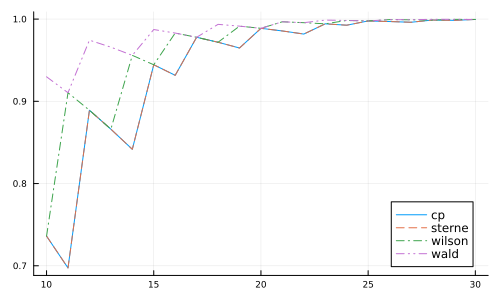

In [4]:
ns = 10:30
p, q = 0.5, 0.1
plot(ns, n -> power(pvalue_cp, n, p, q); label="cp")
plot!(ns, n -> power(pvalue_sterne, n, p, q); label="sterne", ls=:dash)
plot!(ns, n -> power(pvalue_wilson, n, p, q); label="wilson", ls=:dashdot)
plot!(ns, n -> power(pvalue_wald, n, p, q); label="wald", ls=:dashdotdot)
plot!(xtick=10:5:100)
plot!(legend=:bottomright)

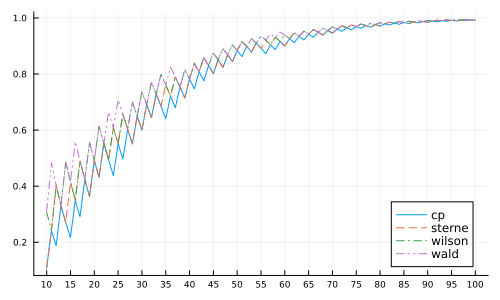

In [5]:
ns = 10:100
p, q = 0.55, 0.33
plot(ns, n -> power(pvalue_cp, n, p, q); label="cp")
plot!(ns, n -> power(pvalue_sterne, n, p, q); label="sterne", ls=:dash)
plot!(ns, n -> power(pvalue_wilson, n, p, q); label="wilson", ls=:dashdot)
plot!(ns, n -> power(pvalue_wald, n, p, q); label="wald", ls=:dashdotdot)
plot!(xtick=10:5:100)
plot!(legend=:bottomright)

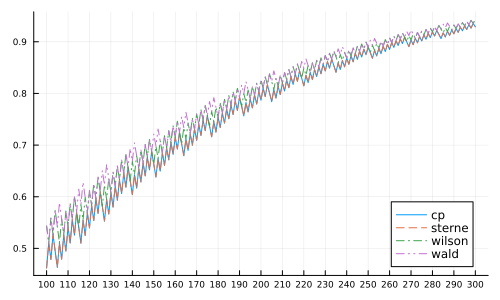

In [6]:
ns = 100:300
p, q = 0.5, 0.4
plot(ns, n -> power(pvalue_cp, n, p, q); label="cp")
plot!(ns, n -> power(pvalue_sterne, n, p, q); label="sterne", ls=:dash)
plot!(ns, n -> power(pvalue_wilson, n, p, q); label="wilson", ls=:dashdot)
plot!(ns, n -> power(pvalue_wald, n, p, q); label="wald", ls=:dashdotdot)
plot!(xtick=10:10:300)
plot!(legend=:bottomright)